# Transformers (Theory)

## General

### What differentiates transformers from RNNs (LSTMs)?

The magic of transformers is that they transform time into space (I believe this formulation is credited to Jacob Cannell).

RNNs read data serially, one element at a time. Transformers read the entire sequence at once. This allows transformers to parallelize the computation and make much more effective use of the modern paradigm of GPUs. 

### Where do privileged bases in transformers come from?

- **Tokens**: with tokens, we *explicitly* choose a one-hot encoding of the vocabulary. That is, each dimension corresponds to a unique (subword) token. 
- **Attention patterns**: the priveleged basis is due to the positional encoding of tokens (i.e., the autoregressive mask used in the softmax). 
- **MLP activations**: the nonlinearities activation functions operate neuron-by-neuron, so a rotation over pre-activations is not invertible post-activation. 

In contrast, the residual stream does *not* have a privileged basis. This is easy to see under the transformation $W_E \to P W_E$ and $W_U \to W_U P^{-1}$. 

The same holds for the query, key, and value vectors ($W_V \to P W_V$, $W_O \to $W_O P^{-1}$, $W_K \to P W_K$, $W_Q^T \to W_Q^T P^{-1}$).


### Why do we divide by $\sqrt{d}$ in the attention layer?

$$A= \text{softmax}^*\left(\frac{QK^T}{\sqrt{d}}\right) V$$

This helps with numerical stability of gradients. 

More precisely: $\text{var}[QK^T] \propto d$, so this is equivalent to standardizing the inputs to the softmax.

## Training

### What is the difference between masked language modeling and next sentence prediction?

- **Masked language modeling** is when we ask a model to "fill in the blank."
- **Next sentence prediction** is when we ask a model to predict the order of two sentences selected from some larger context.

### How might you generate text from a masked language model?

Iteratively ask it to predict the masked unit at the end of a sequence.
You can do this greedily or sample from the distribution of predictions (or interpolate between the two with a temperature parameter).


Cf. [Wang & Cho (2019)](https://arxiv.org/pdf/1902.04094.pdf)


## Tokenisation and embedding

### How does the expected cosine similarity between two random vectors relate to the dimension $D$?

The cosine similarity is defined as:

$$\cos(\theta) = \frac{u^Tv}{\|u\|\|v\|} = \frac{\sum_i u_i v_i}{\|u\|\|v\|}$$

If we have two basis vectors $u$ and $v$ of length $l$, then the odds of them being aligned (or antialigned) is $1/d$, and the expected cosine similarity is $1/d$. 

The same will hold for two random non-basis aligned vectors. You can choose a rotation that maps the first vector onto a basis-aligned vector. 

### Experiment with the `transformers` library

In [2]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
ex = "Here's an example of some text. ABC. 123?"
ex_tokenized = tokenizer.tokenize(ex)
ex_encoded = tokenizer.encode(ex)
ex_decoded = tokenizer.decode(ex_encoded)
ex_encoded

[101,
 2182,
 1005,
 1055,
 2019,
 2742,
 1997,
 2070,
 3793,
 1012,
 5925,
 1012,
 13138,
 1029,
 102]

### Play around with `torch.nn.Embedding`

In [10]:
import torch as t
from torch import nn

embedding = nn.Embedding(10, 3)
input_ = t.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input_)

tensor([[[ 0.3773,  0.1753,  0.1214],
         [-1.8003, -0.7054,  1.6686],
         [ 2.0220, -1.7437, -0.9749],
         [ 1.0495, -0.8345, -0.1550]],

        [[ 2.0220, -1.7437, -0.9749],
         [-1.5084,  0.0811,  0.0255],
         [-1.8003, -0.7054,  1.6686],
         [ 0.1641,  0.5839,  0.1092]]], grad_fn=<EmbeddingBackward0>)

## Positional Encoding

## Sinusoidal Positional Encoding

Text(0.5, 1.0, 'Sinusoidal encoding')

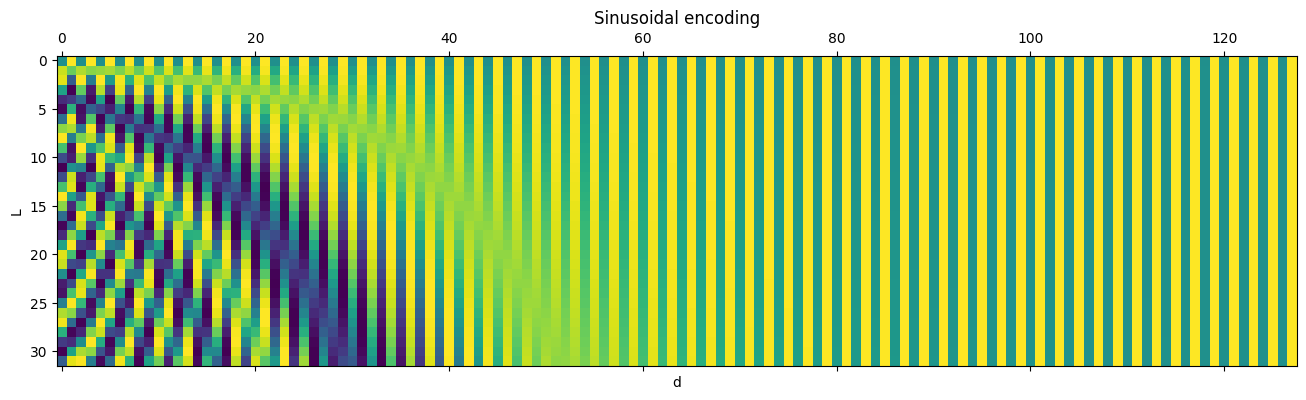

In [26]:
from matplotlib import pyplot as plt

def sinusoidal_encoding(i: int | t.Tensor, d: int | t.Tensor, n_dims: int): 
    return (
        t.sin(i / 10000 ** (d / n_dims)) * (d % 2 == 0)
        + t.cos(i / 10000 ** ((d - 1) / n_dims)) * (d % 2 == 1)
    )

embeddings = sinusoidal_encoding(
    t.arange(32).unsqueeze(1),
    t.arange(128).unsqueeze(0),
    128
)

plt.matshow(embeddings)
plt.ylabel("L")
plt.xlabel("d")
plt.title("Sinusoidal encoding")

Text(0.5, 1.0, 'Dot product between embeddings')

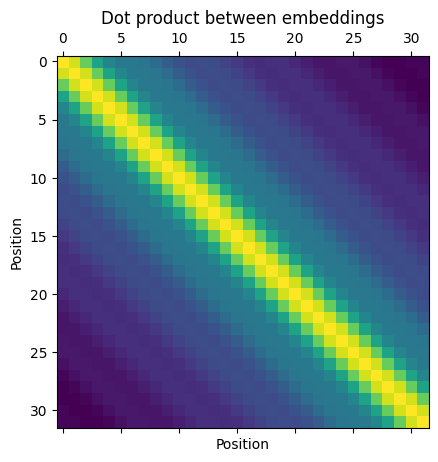

In [25]:
dot_products = embeddings @ embeddings.T
plt.matshow(dot_products)
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Dot product between embeddings")

## Layer Normalization

### Given language data of shape `(batch, sequence, embedding)`, what layer does Layer Norm normalize over?

It normalizes over `embedding`.

### Play around with `LayerNorm`

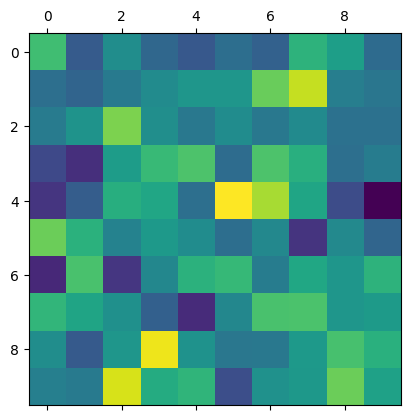

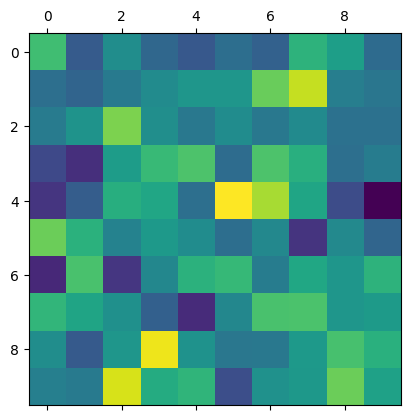

In [38]:
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = t.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)

# Activate module
layer_norm(embedding)

# Image Example
N, C, H, W = 20, 5, 10, 10
input = t.randn(N, C, H, W)


# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

plt.matshow(input[0, 0, :, :])
plt.show()
plt.matshow(output[0, 0, :, :].detach().clone().numpy())


### Explain Dropout 

During training, dropout masks a subset $Np$ of the activations in a model and increases the activation of the remaining $N(1-p)$ neurons by $(1-p)^{-1}$.

During testing, dropout does nothing. 

## Softmax and Activation Functions

From that the softmax is invariant under adding a constant c each input dimension.

$$ \text{softmax}(\mathbf{x} + \mathbf{c}) = \frac{\exp(\mathbf{x} + \mathbf{c})}{\sum_j \exp {x_j + c}},$$

where $\mathbf{c}$ is a constant vector, with $c_i = c\, \forall i$.

Then,

$$P(x_i + c) = \frac{\exp(x_i + c)}{\sum_j \exp {x_j + c}} = \frac{\exp c}{\exp c}\frac{\exp(x_i)}{\sum_j \exp x_j} = \frac{\exp x_i}{\sum_j \exp x_j}$$

## What is the effect of temperature?

Higher temperature "smooths out" the distribution towards a more uniform distribution. 

Lower temperature "freezes" the distribution around its peak.

From physics, this makes sense: temperature is the Legendre dual to entropy.

## Gelu



/Users/Jesse/.local/share/virtualenvs/notes-Szvzhu7a/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


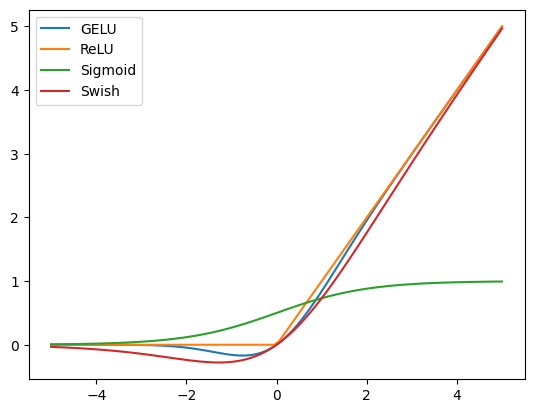

In [45]:
def gelu(x: t.Tensor) -> t.Tensor:
    return x * t.distributions.normal.Normal(loc=0., scale=1.).cdf(x)

def swish(x: t.Tensor) -> t.Tensor:
    return x * t.sigmoid(x)

x = t.linspace(-5, 5, 100)
plt.plot(x, gelu(x))
plt.plot(x, nn.functional.relu(x))
plt.plot(x, nn.functional.sigmoid(x))
plt.plot(x, swish(x))
plt.legend(["GELU", "ReLU", "Sigmoid", "Swish"])
